In [1]:
import requests
import pandas as pd
import numpy as np

### Load patent and classification information

In [2]:
def readTSV(fn):
    return (pd.DataFrame(pd.read_csv(fn, sep='\t')))

In [3]:
asg_df = readTSV('company_patent_info.tsv')

In [4]:
asg_df.dtypes

pid          int64
abstract    object
date        object
name        object
dtype: object

In [5]:
#different classification information
patent_cpc_df = readTSV('patent_cpc_samples.tsv')

In [6]:
patent_wipo_df[patent_wipo_df['pid'] == 7963585]

,pid,sector_title,field_title
0,7963585,Mechanical engineering,Transport


In [7]:
#get classes for each company
total_df = asg_df.copy()
total_df = total_df.drop(columns=['abstract', 'date'], axis=1)

In [8]:
total_df = total_df.merge(patent_cpc_df, on='pid', how='inner')

In [9]:
total_df = total_df.drop_duplicates()

In [10]:
asg_cpc_cnt_df = total_df.groupby(['name', 'cpc']).count().reset_index()
asg_cpc_cnt_df.columns = ['name', 'cpc', 'cnt']

In [11]:
asg_cpc_cnt_df.head()

,name,cpc,cnt
0,Apple,A01F,3
1,Apple,A01G,2
2,Apple,A01K,72
3,Apple,A01N,1
4,Apple,A23C,3


In [12]:
cpc_cnt_matrix = asg_cpc_cnt_df.pivot('name', 'cpc', 'cnt')
company_list = list(cpc_cnt_matrix.index)
company_index = dict(zip(company_list,range(len(company_list))))
cpc_cnt_matrix = np.nan_to_num(cpc_cnt_matrix)

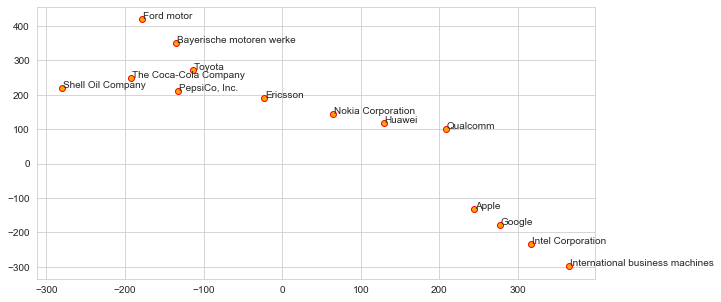

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
result = tsne.fit_transform(cpc_cnt_matrix)
labels = company_list

plt.figure(figsize=(10, 5))
plt.scatter(result[:, 0], result[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, result[:, 0], result[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [43]:
#calculate similarity between companies based on t-SNE result
from scipy.spatial import distance_matrix
df = pd.DataFrame(result, columns=['x_cord', 'y_cord'], index=company_list)
company_distance_tsne_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

In [45]:
company_distance_tsne_df.head()

,Apple,Bayerische motoren werke,Ericsson,Ford motor,Google,Huawei,Intel Corporation,International business machines,Nokia Corporation,"PepsiCo, Inc.",Qualcomm,Shell Oil Company,The Coca-Cola Company,Toyota
Apple,0.000000,612.706116,417.788483,694.376526,56.605614,273.417297,126.233986,206.582672,327.730408,509.539642,234.933945,631.391968,578.070496,539.776550
Bayerische motoren werke,612.706116,0.000000,195.348541,82.086220,669.206970,352.359528,738.734558,819.143494,287.705322,138.637939,423.803131,194.494751,117.066010,80.128891
Ericsson,417.788483,195.348541,0.000000,277.355469,474.195740,168.616135,543.644592,624.042175,99.421280,112.260086,247.215576,259.210388,179.044998,122.936623
Ford motor,694.376526,82.086220,277.355469,0.000000,750.914185,431.709717,820.476929,900.884155,368.415100,213.118835,500.903320,223.426041,172.225647,160.489838
Google,56.605614,669.206970,474.195740,750.914185,0.000000,329.352325,69.628418,149.993027,384.321320,564.807434,286.997528,684.356506,633.048523,596.005432


In [17]:
#use network property to calculate the similarity between companies
def calculateSoftSimilarity(n1_set, n2_set, n1_dict, n2_dict, g):
    unionSet = n1_set.union(n2_set)
    n1_vector = [None] * len(unionSet)
    n2_vector = [None] * len(unionSet)
    idx = 0
    for item in unionSet:
        if (item in n1_set):
            n1_vector[idx] = n1_dict[item]
        else:
            n1_vector[idx] = 0
        if (item in n2_set):
            n2_vector[idx] = n2_dict[item]
        else:
            n2_vector[idx] = 0
        idx += 1
    denominator = 0
    base_a = 0
    base_b = 0
    nodes_list = list(unionSet)
    for i in range(len(unionSet)):
        i_node = nodes_list[i]
        a_i = n1_vector[i]
        b_i = n2_vector[i]
        for j in range(len(unionSet)):
            j_node = nodes_list[j]
            a_j = n1_vector[j]   
            b_j = n2_vector[j]            
            if (g.has_edge(i_node, j_node)):
                s = g[i_node][j_node]['weight']
                denominator += a_i * b_j * s
                base_a += a_i * a_j * s
                base_b += b_i * b_j * s
            else:
                if (i == j):
                    denominator += a_i * b_j
                    base_a += a_i * a_j
                    base_b += b_i * b_j
    weight = denominator / math.sqrt(base_a * base_b)
    return weight

In [22]:
cpc_cnt_matrix_df = asg_cpc_cnt_df.pivot('name', 'cpc', 'cnt')
cpc_cnt_matrix_df = cpc_cnt_matrix_df.fillna(0)
asg_dict_cnt = cpc_cnt_matrix_df.to_dict(orient='index')

In [72]:
#remove classes with count = 0
remove_list =  ['Y10S', 'Y10T', 'Y04S', 'Y02A', 'Y02B', 'Y02C','Y02D','Y02E','Y02P','Y02T','Y02W','D10B','F05B','F05C','F05D', 'G16H']
def getSet(dict_set):
#     print (dict_set)
#     print ("===")
    cleaned_set = set()
    for key, value in dict_set.items():
        #print (value)
        if ((value != 0.0) and (key not in remove_list)):
            cleaned_set.add(key)
    return cleaned_set

In [80]:
import networkx as nx
import math
row_list = []
g = nx.read_weighted_edgelist('./co_reference_network_cpc4_1976_2016.txt')
for i in range(len(company_list)):
    cls1_set = asg_dict_cnt[company_list[i]]
    for j in range(i+1, len(company_list)):
        cls2_set = asg_dict_cnt[company_list[j]]
        w = calculateSoftSimilarity(getSet(cls1_set), getSet(cls2_set), cls1_set, cls2_set, g)
        row_list.append({"weight": w, "asg_A": company_list[i], "asg_B": company_list[j]})
company_cosine_similarity_df = pd.DataFrame(row_list)

In [114]:
company_cosine_similarity_df

,weight,asg_A,asg_B
0,0.314492,Apple,Bayerische motoren werke
1,0.747113,Apple,Ericsson
2,0.270769,Apple,Ford motor
3,0.973257,Apple,Google
4,0.780113,Apple,Huawei
...,...,...,...
86,0.130758,Qualcomm,The Coca-Cola Company
87,0.264259,Qualcomm,Toyota
88,0.229644,Shell Oil Company,The Coca-Cola Company
89,0.219306,Shell Oil Company,Toyota


In [86]:
row_list = []
for i in range(len(company_list)):
    for j in range(i+1, len(company_list)):
        row_list.append({"tsne_w": company_distance_tsne_df[company_list[i]][company_list[j]],
                        "asg_A": company_list[i],
                        "asg_B": company_list[j]})
company_tsne_df = pd.DataFrame(row_list)

In [104]:
comp_df = company_tsne_df.merge(company_cosine_similarity_df, on=['asg_A', 'asg_B'], how='inner')

In [100]:
comp_df['tsne_w'] = comp_df['tsne_w'].apply(lambda x: 1/(1+x))

In [101]:
comp_df.sort_values(by=['tsne_w'], axis = 0)

,tsne_w,asg_A,asg_B,weight
39,0.001109,Ford motor,International business machines,0.255786
73,0.001206,International business machines,Shell Oil Company,0.082540
38,0.001217,Ford motor,Intel Corporation,0.258142
18,0.001219,Bayerische motoren werke,International business machines,0.270158
74,0.001279,International business machines,The Coca-Cola Company,0.174131
...,...,...,...,...
47,0.014159,Google,Intel Corporation,0.932077
83,0.014167,"PepsiCo, Inc.",The Coca-Cola Company,0.922040
57,0.014200,Huawei,Nokia Corporation,0.983046
84,0.015319,"PepsiCo, Inc.",Toyota,0.289434


In [102]:
comp_df.corr()

,tsne_w,weight
tsne_w,1.00000,0.43691
weight,0.43691,1.00000


In the comparison, the correlation between these two methods is not high. It might be that cosine similarity works better when there are many features (i.e., higher dimension). In this case, it would not suggest to use cosine similiarity or soft cosine similarity to compare the technology portfolio of companies directly, because this measure does not consider magnitude of vectors. The cosine similarity is more like a "direction" measure rather than a magnitude measure. 